In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import math
import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

import sklearn 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import IvysaurusModel
import FileHelper

In [2]:
fileNames = glob.glob('/Users/isobel/Desktop/DUNE/Ivysaurus/files/ivysaurus_nu*.root')
trainVarFile = '/Users/isobel/Desktop/DUNE/Ivysaurus/files/trainVarArrays.npz'
print(fileNames)

['/Users/isobel/Desktop/DUNE/Ivysaurus/files/ivysaurus_nutau.root', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/ivysaurus_nu.root', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/ivysaurus_nue.root']


In [3]:
# Here we'll put some hyperparameters...

dimensions = 12
nClasses = 6
         
ntrain = 343573
ntest  = 38175

nEpochs = 10
batchSize = 64
learningRate = 1e-4

In [4]:
# Here we'll get our information...

useExistingVariableFile = False

if not (useExistingVariableFile):

    # Read tree
    startGridU, startGridV, startGridW, endGridU, endGridV, endGridW, y = FileHelper.readTree(fileNames, dimensions, nClasses)

    # This should shuffle things so that the indicies are still linked
    startGridU, startGridV, startGridW, endGridU, endGridV, endGridW, y = sklearn.utils.shuffle(startGridU, startGridV, startGridW, endGridU, endGridV, endGridW, y)

    startGridU_train = startGridU[:ntrain]
    startGridV_train = startGridV[:ntrain]
    startGridW_train = startGridW[:ntrain]

    startGridU_test = startGridU[ntrain:(ntrain + ntest)]
    startGridV_test = startGridV[ntrain:(ntrain + ntest)]
    startGridW_test = startGridW[ntrain:(ntrain + ntest)]

    endGridU_train = endGridU[:ntrain]
    endGridV_train = endGridV[:ntrain]
    endGridW_train = endGridW[:ntrain]

    endGridU_test = endGridU[ntrain:(ntrain + ntest)]
    endGridV_test = endGridV[ntrain:(ntrain + ntest)]
    endGridW_test = endGridW[ntrain:(ntrain + ntest)]

    y_train = y[:ntrain]
    y_test = y[ntrain:(ntrain + ntest)]
    
    np.savez(trainVarFile, startGridU_train=startGridU_train, startGridV_train=startGridV_train, startGridW_train=startGridW_train, startGridU_test=startGridU_test, startGridV_test=startGridV_test, startGridW_test=startGridW_test, endGridU_train=endGridU_train, endGridV_train=endGridV_train, endGridW_train=endGridW_train, endGridU_test=endGridU_test, endGridV_test=endGridV_test, endGridW_test=endGridW_test, y_train=y_train, y_test=y_test)   

Reading tree:  /Users/isobel/Desktop/DUNE/Ivysaurus/files/ivysaurus_nutau.root , This may take a while...
Reading tree:  /Users/isobel/Desktop/DUNE/Ivysaurus/files/ivysaurus_nu.root , This may take a while...
Reading tree:  /Users/isobel/Desktop/DUNE/Ivysaurus/files/ivysaurus_nue.root , This may take a while...
We have  381748  PFParticles overall!
nMuons:  40622
nProtons:  106319
nPions:  90747
nElectrons:  40027
nPhotons:  100690
nOther:  94090


In [5]:
if (useExistingVariableFile):
    data = np.load(trainVarFile)
    
    startGridU_train = data['startGridU_train']
    startGridV_train = data['startGridV_train']
    startGridW_train = data['startGridW_train']
    
    startGridU_test = data['startGridU_test']
    startGridV_test = data['startGridV_test'] 
    startGridW_test = data['startGridW_test']
    
    endGridU_train = data['endGridU_train']
    endGridV_train = data['endGridV_train']
    endGridW_train = data['endGridW_train']
    
    endGridU_test = data['endGridU_test']
    endGridV_test = data['endGridV_test']
    endGridW_test = data['endGridW_test']
    
    y_train = data['y_train']
    y_test = data['y_test']

In [6]:
print('startGridU_train: ', startGridU_train.shape)
print('startGridV_train: ', startGridV_train.shape)
print('startGridW_train: ', startGridW_train.shape)
print('startGridU_test: ', startGridU_test.shape)
print('startGridV_test: ', startGridV_test.shape)
print('startGridW_test: ', startGridW_test.shape)
   
print('endGridU_train: ', endGridU_train.shape)    
print('endGridV_train: ', endGridV_train.shape)
print('endGridW_train: ', endGridW_train.shape)
print('endGridU_test: ', endGridU_test.shape)     
print('endGridV_test: ', endGridV_test.shape)     
print('endGridW_test: ', endGridW_test.shape) 
    
print('y_train: ', y_train.shape)
print('y_test', y_test.shape)

startGridU_train:  (343573, 12, 12)
startGridV_train:  (343573, 12, 12)
startGridW_train:  (343573, 12, 12)
startGridU_test:  (38175, 12, 12)
startGridV_test:  (38175, 12, 12)
startGridW_test:  (38175, 12, 12)
endGridU_train:  (343573, 12, 12)
endGridV_train:  (343573, 12, 12)
endGridW_train:  (343573, 12, 12)
endGridU_test:  (38175, 12, 12)
endGridV_test:  (38175, 12, 12)
endGridW_test:  (38175, 12, 12)
y_train:  (343573, 6)
y_test (38175, 6)


In [7]:
# Work out the mean and variance

meanStartU = np.mean(startGridU_train)
meanStartV = np.mean(startGridV_train)
meanStartW = np.mean(startGridW_train)

meanEndU = np.mean(endGridU_train)
meanEndV = np.mean(endGridV_train)
meanEndW = np.mean(endGridW_train)

varStartU = np.var(startGridU_train)
varStartV = np.var(startGridV_train)
varStartW = np.var(startGridW_train)

varEndU = np.var(endGridU_train)
varEndV = np.var(endGridV_train)
varEndW = np.var(endGridW_train)

print('meanStartU: ', meanStartU)
print('meanStartV: ', meanStartV)
print('meanStartW: ', meanStartW)

print('varStartU: ', varStartU)
print('varStartV: ', varStartV)
print('varStartW: ', varStartW)

print('meanEndU: ', meanEndU)
print('meanEndV: ', meanEndV)
print('meanEndW: ', meanEndW)

print('varEndU: ', varEndU)
print('varEndV: ', varEndV)
print('varEndW: ', varEndW)

meanStartU:  0.00030429318
meanStartV:  0.00029485952
meanStartW:  0.00034490263
varStartU:  1.6634001e-06
varStartV:  1.5382146e-06
varStartW:  2.3883651e-06
meanEndU:  0.00016638511
meanEndV:  0.00015862062
meanEndW:  0.00018177569
varEndU:  8.55769e-07
varEndV:  7.4437867e-07
varEndW:  1.1424167e-06


In [8]:
ivysaurusCNN = IvysaurusModel.IvysaurusIChooseYou(dimensions, nClasses, meanStartU, varStartU, meanStartV, varStartV, meanStartW, varStartW, meanEndU, varEndU, meanEndV, varEndV, meanEndW, varEndW)
#ivysaurusCNN.summary()

In [9]:
# Define the optimiser and compile the model
optimiser = optimizers.legacy.Adam(learning_rate=learningRate)
ivysaurusCNN.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['accuracy'])

In [ ]:
# Fit that model!

# Reduce the learning rate by a factor of ten when required
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1)
history = ivysaurusCNN.fit([startGridU_train, endGridU_train, startGridV_train, endGridV_train, startGridW_train, endGridW_train], y_train, 
    batch_size = batchSize, validation_data=([startGridU_test, endGridU_test, startGridV_test, endGridV_test, startGridW_test, endGridW_test], y_test), 
    shuffle=True, epochs=nEpochs)

Epoch 1/10
5369/5369 [==============================] - 277s 51ms/step - loss: 1.0107 - accuracy: 0.6032 - val_loss: 0.8815 - val_accuracy: 0.6626
Epoch 2/10
5369/5369 [==============================] - 310s 58ms/step - loss: 0.8384 - accuracy: 0.6783 - val_loss: 0.8044 - val_accuracy: 0.6928
Epoch 3/10
5369/5369 [==============================] - 339s 63ms/step - loss: 0.7811 - accuracy: 0.7026 - val_loss: 0.7858 - val_accuracy: 0.7007
Epoch 4/10
5369/5369 [==============================] - 330s 61ms/step - loss: 0.7462 - accuracy: 0.7162 - val_loss: 0.7345 - val_accuracy: 0.7209
Epoch 5/10
5369/5369 [==============================] - 329s 61ms/step - loss: 0.7211 - accuracy: 0.7267 - val_loss: 0.7556 - val_accuracy: 0.7142
Epoch 6/10
3735/5369 [===================>..........] - ETA: 1:39 - loss: 0.7018 - accuracy: 0.7343

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


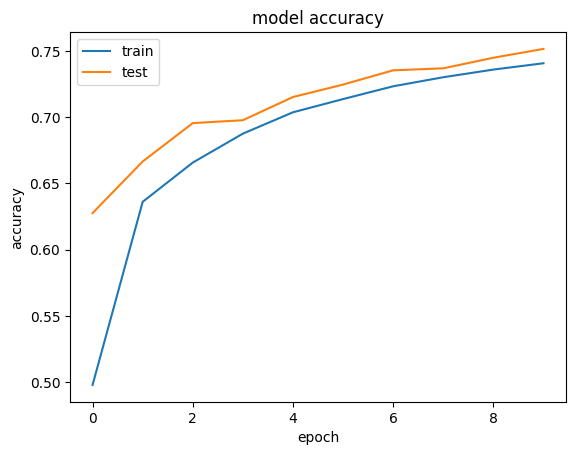

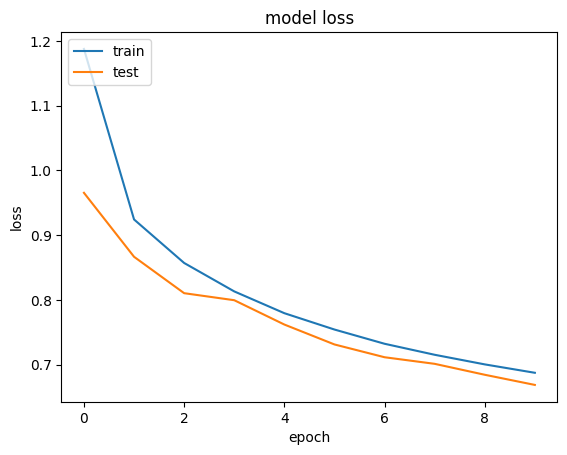

In [10]:
# Evaluate training

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
# Use the network to predict the category of the test sample

y_pred = ivysaurusCNN.predict([startGridU_test, endGridU_test, startGridV_test, endGridV_test, startGridW_test, endGridW_test])
confMatrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))


274/274 [==============================] - 2s 7ms/step


In [15]:
incorrectIndicies = []

for i in range (y_pred.shape[0]) :
    prediction = np.argmax(y_pred[i])
    truth = np.argmax(y_test[i])
    if (prediction != truth) :
        incorrectIndicies.append([i, prediction, truth])
    
print(incorrectIndicies)                

[[14, 0, 2], [15, 0, 2], [20, 2, 0], [30, 0, 1], [36, 4, 0], [38, 2, 1], [40, 0, 2], [43, 4, 2], [46, 0, 2], [51, 0, 2], [58, 4, 2], [59, 0, 2], [64, 1, 2], [65, 0, 2], [67, 4, 3], [70, 0, 4], [73, 2, 0], [76, 1, 2], [77, 2, 0], [81, 0, 4], [85, 1, 0], [86, 4, 3], [90, 2, 0], [92, 4, 0], [95, 2, 1], [98, 0, 2], [99, 0, 5], [101, 2, 1], [103, 0, 2], [104, 0, 2], [108, 0, 2], [109, 0, 2], [112, 4, 1], [113, 2, 1], [116, 0, 1], [118, 4, 2], [119, 0, 2], [121, 0, 2], [129, 4, 2], [132, 0, 2], [135, 0, 1], [136, 0, 2], [141, 2, 4], [142, 0, 1], [144, 4, 2], [145, 1, 2], [148, 4, 2], [160, 0, 2], [161, 2, 0], [163, 0, 2], [167, 0, 2], [170, 0, 2], [177, 0, 2], [179, 2, 0], [181, 2, 1], [184, 2, 4], [188, 2, 4], [191, 4, 1], [193, 0, 1], [195, 0, 2], [198, 4, 2], [202, 0, 2], [209, 0, 2], [212, 2, 1], [216, 0, 2], [218, 2, 0], [221, 0, 2], [222, 4, 2], [225, 2, 0], [226, 0, 2], [229, 0, 2], [231, 0, 2], [232, 0, 1], [243, 1, 2], [244, 1, 0], [248, 4, 2], [249, 2, 0], [253, 0, 2], [259, 0, 4],

trueSums:  [2361 2297 1835   80 2084   82]
predSums:  [2508 2075 1746    9 2401    0]
[[1789   22  362    0  188    0]
 [ 120 1838  278    0   61    0]
 [ 529  159  999    0  148    0]
 [   6    0    5    5   64    0]
 [  51   21   72    4 1936    0]
 [  13   35   30    0    4    0]]


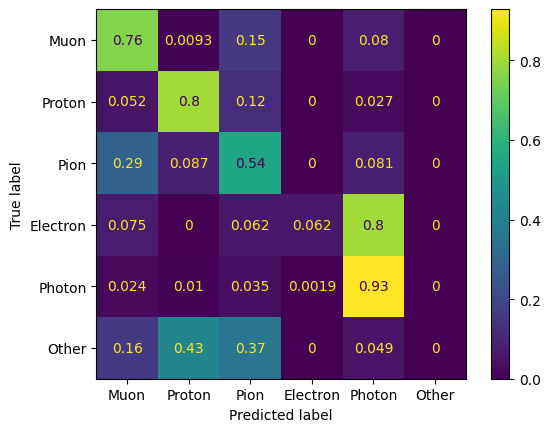

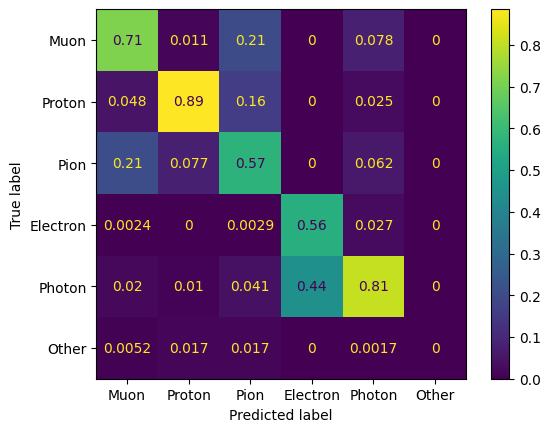

In [12]:
# Let's look at the confusion matrix

confMatrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

trueSums = np.sum(confMatrix, axis=1)
predSums = np.sum(confMatrix, axis=0)

print('trueSums: ', trueSums)
print('predSums: ', predSums)

trueNormalised = np.zeros(shape=(nClasses, nClasses))
predNormalised = np.zeros(shape=(nClasses, nClasses))

for trueIndex in range(nClasses) : 
    for predIndex in range(nClasses) :
        nEntries = confMatrix[trueIndex][predIndex]
        if trueSums[trueIndex] > 0 :
            trueNormalised[trueIndex][predIndex] = float(nEntries) / float(trueSums[trueIndex])
        if predSums[predIndex] > 0 :
            predNormalised[trueIndex][predIndex] = float(nEntries) / float(predSums[predIndex])

displayTrueNorm = ConfusionMatrixDisplay(confusion_matrix=trueNormalised, display_labels=["Muon", "Proton", "Pion", "Electron", "Photon", "Other"])
displayTrueNorm.plot()

displayPredNorm = ConfusionMatrixDisplay(confusion_matrix=predNormalised, display_labels=["Muon", "Proton", "Pion", "Electron", "Photon", "Other"])
displayPredNorm.plot()

print(confMatrix)

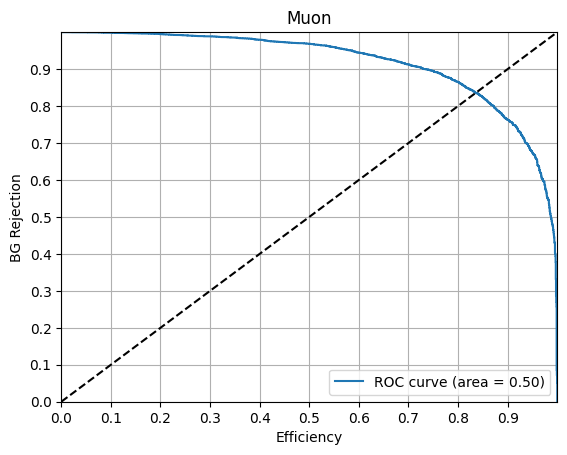

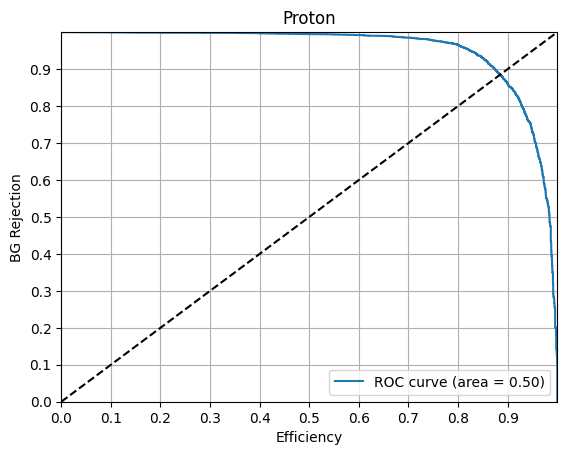

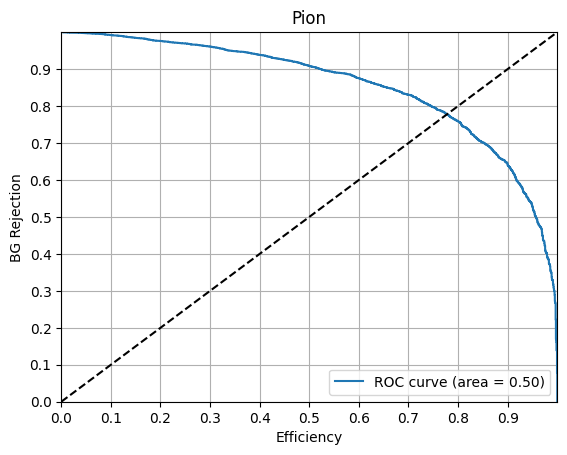

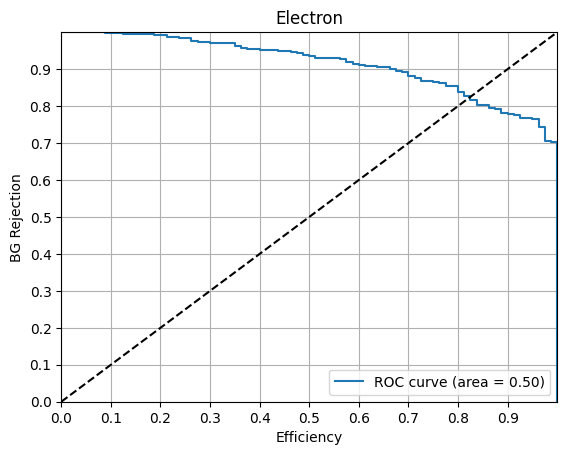

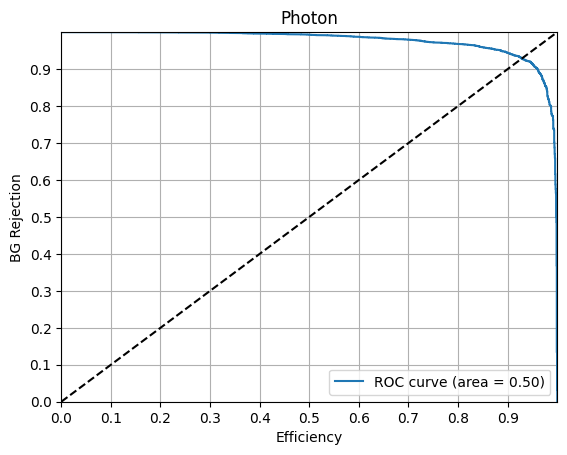

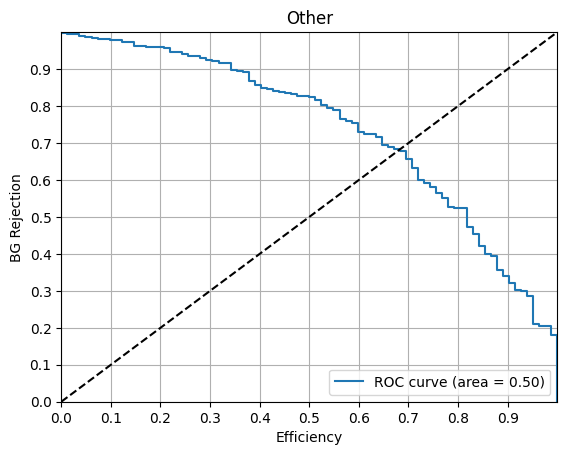

In [17]:
# Compute ROC curve and ROC area for each class

falsePositive = dict()
bkgRejection = dict()
truePositive = dict()
roc = dict()

for i in range(nClasses):
    falsePositive[i], truePositive[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    bkgRejection[i] = 1 - falsePositive[i]
    roc[i] = sklearn.metrics.auc(falsePositive[i], bkgRejection[i])

# Plot of a ROC curve for a specific class

rocCurveTitles = ["Muon", "Proton", "Pion", "Electron", "Photon", "Other"]

for i in range(nClasses):
    plt.figure()
    plt.plot(truePositive[i], bkgRejection[i], label='ROC curve (area = %0.2f)' % roc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xticks(np.arange(0, 1, 0.1))
    plt.yticks(np.arange(0, 1, 0.1))
    plt.xlabel('Efficiency')
    plt.ylabel('BG Rejection')
    plt.title(rocCurveTitles[i])
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

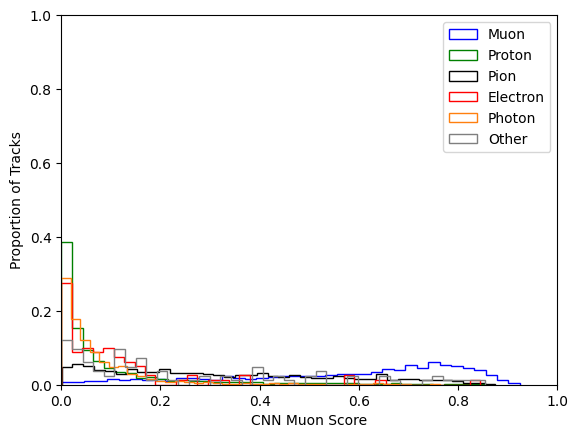

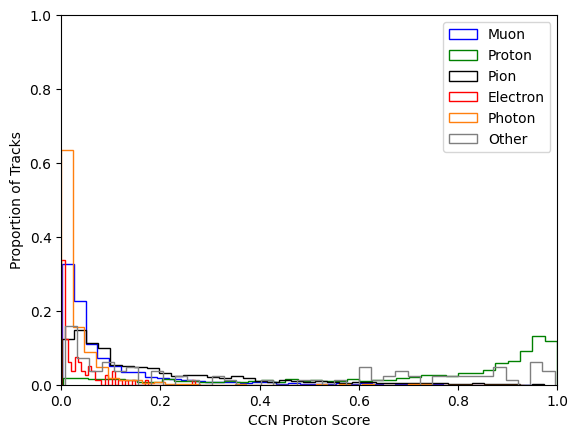

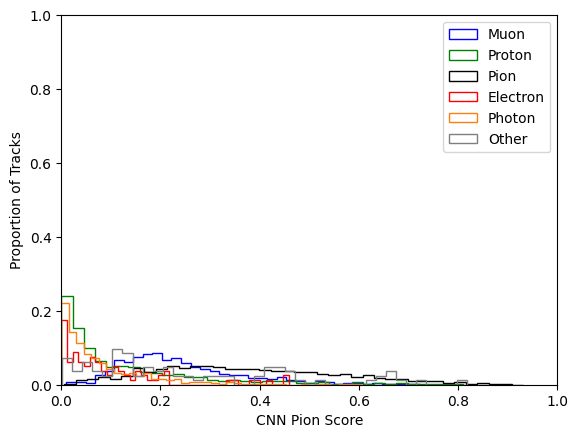

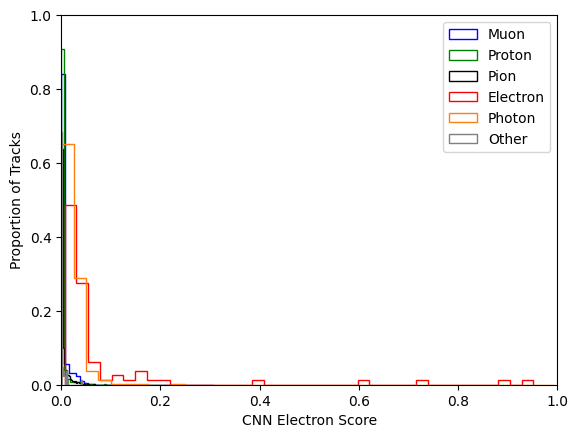

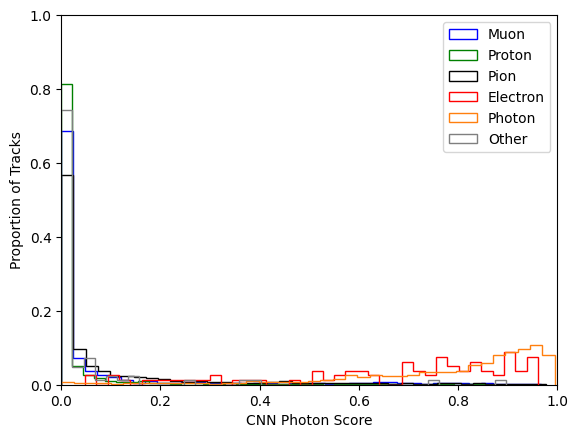

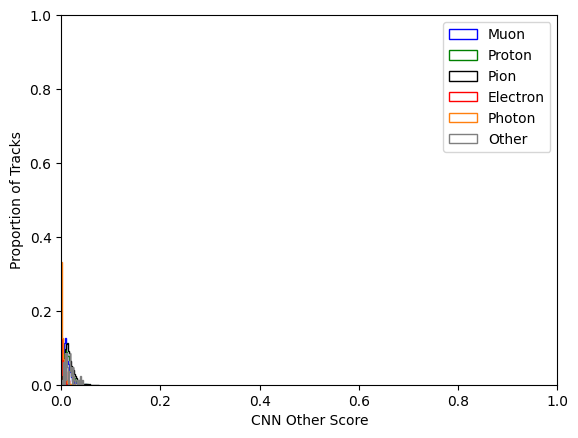

In [19]:
particleColors = ('b', 'g', 'k', 'r', 'tab:orange', 'tab:gray')
histTitles = ('CNN Muon Score', 'CCN Proton Score', 'CNN Pion Score', 'CNN Electron Score', 'CNN Photon Score', 'CNN Other Score')

for i in range(nClasses) :
    for j in range(nClasses) :
        nTrueParticles = trueSums[j]
        weights = np.full(nTrueParticles, 1.0/nTrueParticles)
        plt.hist(y_pred[y_test[:,j] == 1][:,i], bins=40, weights=weights, color=particleColors[j], histtype='step')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel(histTitles[i])
        plt.ylabel('Proportion of Tracks')
        plt.legend(['Muon', 'Proton', 'Pion', 'Electron', 'Photon', 'Other'])
    plt.show()